# Supplemental Figure 1

- Panel A: Histogram of count split by plate
- Panel B: UMAPs split by plate
- Panel C: Density plots of aggregated profiles split by plate

## Import libraries

In [1]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(grid))
suppressPackageStartupMessages(library(patchwork))

Warning message:
“package ‘ggplot2’ was built under R version 4.2.3”
Warning message:
“package ‘patchwork’ was built under R version 4.2.3”


## Set paths

In [2]:
figure_dir <- "../figures/supplementary"
output_supp_figure_1 <- file.path(figure_dir, "supp_figure_1_splitbyplate.png")

## UMAPs per plate

In [3]:
# Path to UMAP results
UMAP_results_dir <- file.path(
    "../../../nf1_cellpainting_data/4.analyze_data/notebooks/UMAP/results/"
)

# Load data
UMAP_results_file <- file.path(UMAP_results_dir, "UMAP_concat_model_plates_sc_feature_selected.tsv")

UMAP_results_df <- readr::read_tsv(UMAP_results_file)

UMAP_results_df <- UMAP_results_df %>%
  mutate(Metadata_Plate = recode(Metadata_Plate,
                        "Plate_3" = "Plate A",
                        "Plate_3_prime" = "Plate B",
                        "Plate_5" = "Plate C"))

dim(UMAP_results_df)
head(UMAP_results_df)

Rows: 22585 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (3): Metadata_Plate, Metadata_genotype, Metadata_Well
dbl (4): Metadata_number_of_singlecells, Metadata_Site, UMAP0, UMAP1

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] 22585     7

Metadata_Plate,Metadata_number_of_singlecells,Metadata_genotype,Metadata_Site,Metadata_Well,UMAP0,UMAP1
<chr>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<dbl>
Plate A,135,Null,9,D10,-1.6084201,0.8945867
Plate B,388,WT,17,G4,2.1205704,2.8444037
Plate B,358,WT,19,D4,-2.6536717,-0.7434336
Plate C,129,Null,11,G11,0.9608944,3.1357698
Plate B,53,Null,18,B11,-2.5349510,1.1791700
Plate A,305,WT,21,D3,2.7670174,1.8998046


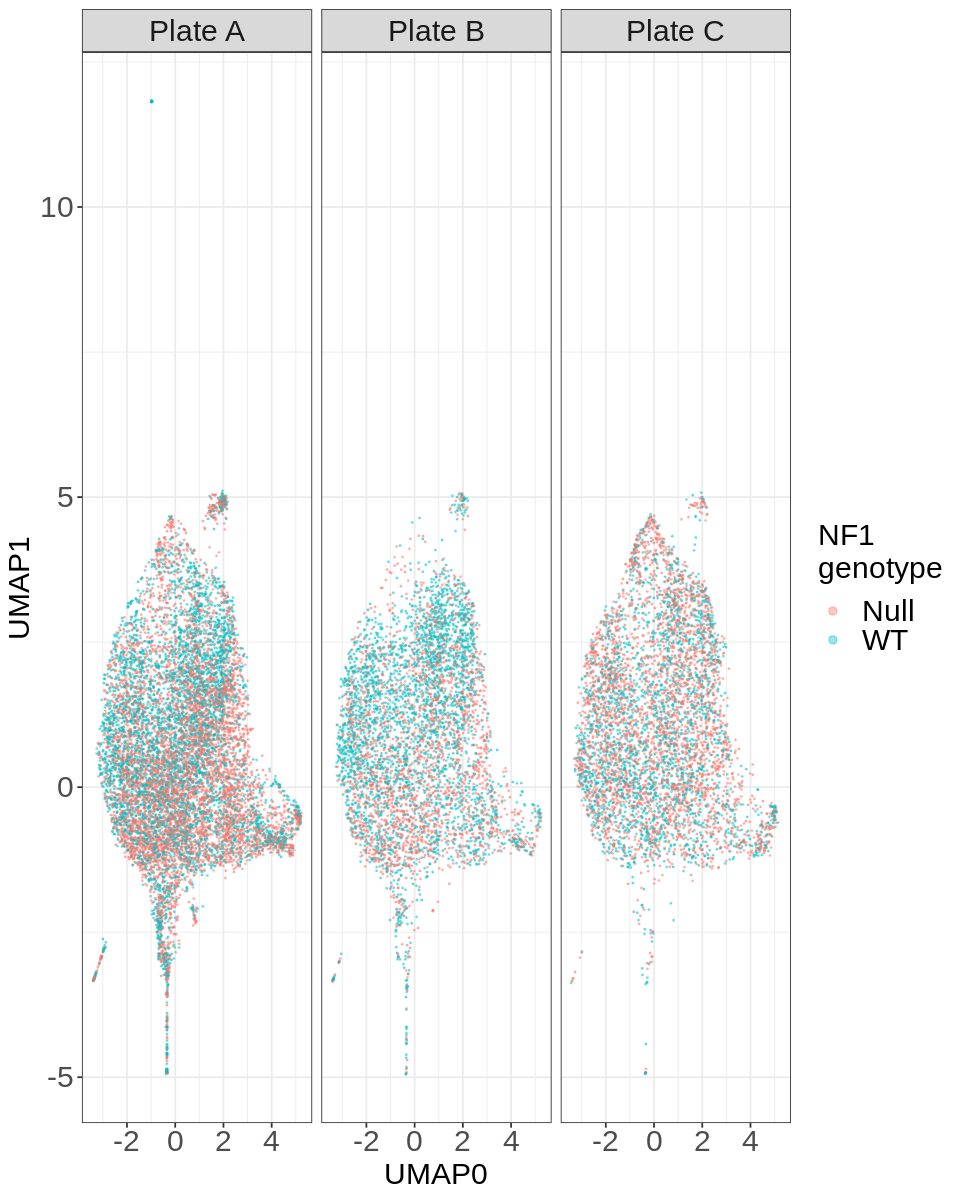

In [4]:
width <- 8
height <- 10
options(repr.plot.width = width, repr.plot.height = height)

umap_fig_gg <- (
  ggplot(UMAP_results_df, aes(x = UMAP0, y = UMAP1))
  + geom_point(
      aes(color = Metadata_genotype),
      size = 0.2,
      alpha = 0.4
  )
  + theme_bw()
  + facet_grid(~Metadata_Plate)
  + guides(
      color = guide_legend(
          override.aes = list(size = 2)
      )
  )
  + labs(x = "UMAP0", y = "UMAP1", color = "NF1\ngenotype")
  # change the text size
  + theme(
      strip.text = element_text(size = 18),
      # x and y axis text size
      axis.text.x = element_text(size = 18),
      axis.text.y = element_text(size = 18),
      # x and y axis title size
      axis.title.x = element_text(size = 18),
      axis.title.y = element_text(size = 18),
      # legend text size
      legend.text = element_text(size = 18),
      legend.title = element_text(size = 18)
  )
)

umap_fig_gg

## Histogram of cell count split by plate

In [5]:
# Replace missing values in Metadata_genotype with "Null"
UMAP_results_df$Metadata_genotype <- na_if(UMAP_results_df$Metadata_genotype, "")

# Group by both Metadata_genotype and Metadata_Plate and summarize the count of rows per group
per_plate_counts <- UMAP_results_df %>%
    group_by(Metadata_genotype, Metadata_Plate) %>%
    summarize(count = n(), .groups = 'drop')

# Confirm any NA values are "Null" strings in Metadata_genotype column
per_plate_counts$Metadata_genotype[is.na(per_plate_counts$Metadata_genotype)] <- "Null"

# View the resulting counts dataframe
dim(per_plate_counts)
per_plate_counts

[1] 6 3

Metadata_genotype,Metadata_Plate,count
<chr>,<chr>,<int>
Null,Plate A,6220
Null,Plate B,2397
Null,Plate C,3390
WT,Plate A,5066
WT,Plate B,3109
WT,Plate C,2403


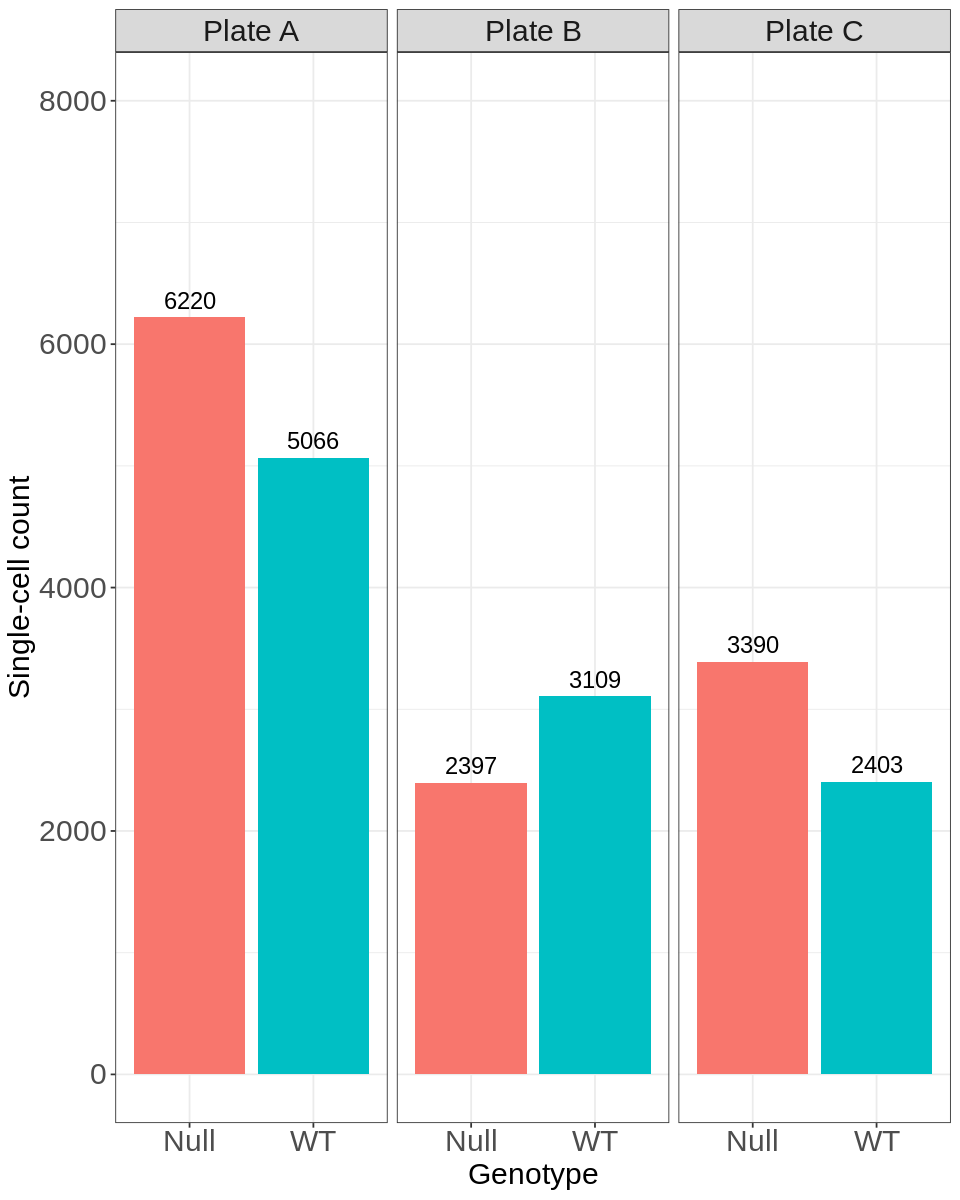

In [6]:
# Create the histogram plot with adjusted dodge width
histogram_plot <- ggplot(per_plate_counts, aes(x = Metadata_genotype, y = count, fill = Metadata_genotype)) +
    geom_bar(stat = "identity", position = position_dodge(width = 1.0)) +  # Adjust dodge width
    geom_text(aes(label = count), position = position_dodge(width = 1.0), vjust = -0.5, size = 5) +  # Adjust dodge width
    labs(x = "Genotype", y = "Single-cell count", fill = "NF1\ngenotype") + 
    ylim(0, 8000) +  # Adjust y-axis limit if needed
    theme_bw() +
    facet_grid(~Metadata_Plate) +  # Facet by Metadata_Plate
    theme(
        # x and y axis text size
        axis.text.x = element_text(size = 18),
        axis.text.y = element_text(size = 18),
        # axis title size
        axis.title.x = element_text(size = 18),
        axis.title.y = element_text(size = 18),
         # Remove legend
        legend.position = "none",
        # Increase facet title size
        strip.text = element_text(size = 18),
        # Keep x-axis ticks
        axis.ticks.x = element_line()
    )

histogram_plot


## Pairwise correlations split by plate

In [7]:
# Path to correlation per plate results
corr_results_dir <- file.path(
    "../../0.data_analysis/plate_correlation_analyses/construct_correlation_data"
)

# Load data
corr_results_file <- file.path(corr_results_dir, "well_agg_plate_genotype_correlations.parquet")
corr_results_df <- arrow::read_parquet(corr_results_file)

# Rename plates in both group columns
corr_results_df <- corr_results_df %>%
  mutate(
    Metadata_Plate__group0 = recode(Metadata_Plate__group0,
                                    "Plate_3" = "Plate A",
                                    "Plate_3_prime" = "Plate B",
                                    "Plate_5" = "Plate C"),
    Metadata_Plate__group1 = recode(Metadata_Plate__group1,
                                    "Plate_3" = "Plate A",
                                    "Plate_3_prime" = "Plate B",
                                    "Plate_5" = "Plate C")
  )

# Filter rows where Metadata_Plate__group0 matches Metadata_Plate__group1
filtered_df <- corr_results_df %>%
    filter(Metadata_Plate__group0 == Metadata_Plate__group1)

# Add a new column `same_genotype` to check if the correlation row is comparing between the same genotype
filtered_df$same_genotype <- filtered_df$Metadata_genotype__group0 == filtered_df$Metadata_genotype__group1

# Check dimensions and head of the filtered dataframe
dim(filtered_df)
head(filtered_df)


[1] 3384    7

correlation,Metadata_Plate__group0,Metadata_Plate__group1,Metadata_genotype__group0,Metadata_genotype__group1,__index_level_0__,same_genotype
<dbl>,<chr>,<chr>,<chr>,<chr>,<int>,<lgl>
0.1102551,Plate A,Plate A,Null,WT,0,FALSE
0.5291495,Plate A,Plate A,Null,WT,1,FALSE
0.2019333,Plate A,Plate A,Null,WT,2,FALSE
-0.1571087,Plate A,Plate A,Null,WT,3,FALSE
0.2337972,Plate A,Plate A,Null,WT,4,FALSE
0.5405582,Plate A,Plate A,Null,WT,5,FALSE


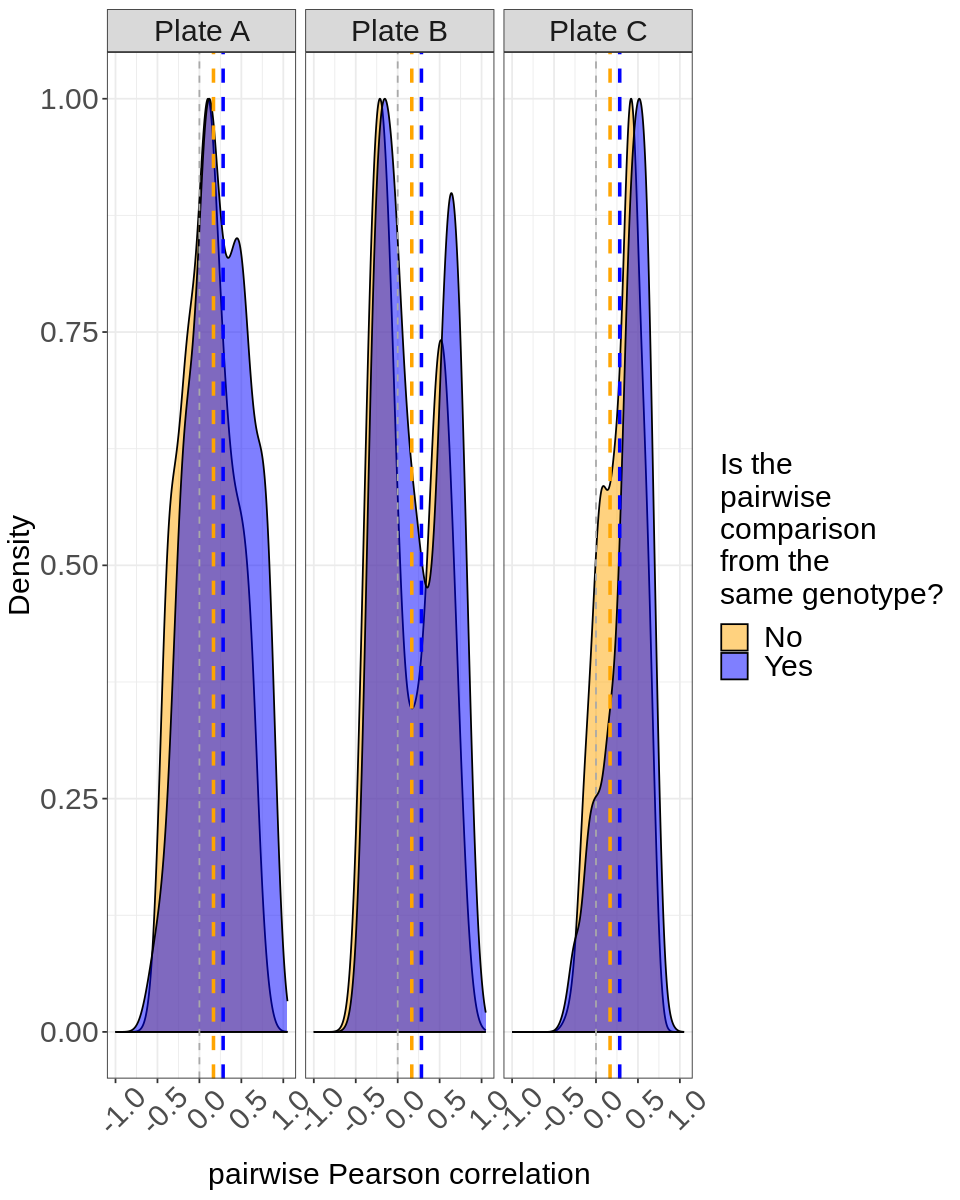

In [8]:
# Calculate mean correlations for each group
mean_values <- filtered_df %>%
  group_by(same_genotype) %>%
  summarize(mean_correlation = mean(correlation))

focus_corr_colors = c(
    "TRUE" = "blue",
    "FALSE" = "orange"
)
focus_corr_labels  = c(
    "TRUE" = "Yes",
    "FALSE" = "No"
)

# Create the plot
genotype_corr_gg <- (
  ggplot(filtered_df, aes(x = correlation, fill = same_genotype))
  + stat_density(aes(y = after_stat(scaled)), geom = "density", alpha = 0.5, position = "identity")
  + scale_fill_manual(
      "Is the\npairwise\ncomparison\nfrom the\nsame genotype?",
      values = focus_corr_colors,
      labels = focus_corr_labels
  )
  + guides(
      color = guide_legend(
          override.aes = list(size = 2)
      )
  )
  + facet_grid(~Metadata_Plate__group0)
  + labs(x = "pairwise Pearson correlation", y = "Density")
  + geom_vline(xintercept = 0, linetype = "dashed", color = "darkgrey")
  + geom_vline(data = mean_values, aes(xintercept = mean_correlation, color = same_genotype), 
               linetype = "dashed", linewidth = 1, show.legend = FALSE)
  + scale_color_manual(values = focus_corr_colors)  # Use the same colors as the fill
  + xlim(-1, 1.05)
  + theme_bw()
  + theme(
      # x and y axis text size
      axis.text.x = element_text(size = 18, angle = 45, margin = margin(t = 12)), # Move x-axis text down
      axis.text.y = element_text(size = 18),
      # x and y axis title size
      axis.title.x = element_text(size = 18),
      axis.title.y = element_text(size = 18),
      # legend text size
      legend.text = element_text(size = 18),
      legend.title = element_text(size = 18),
      # Increase facet title size
      strip.text = element_text(size = 18),
  )
)

genotype_corr_gg


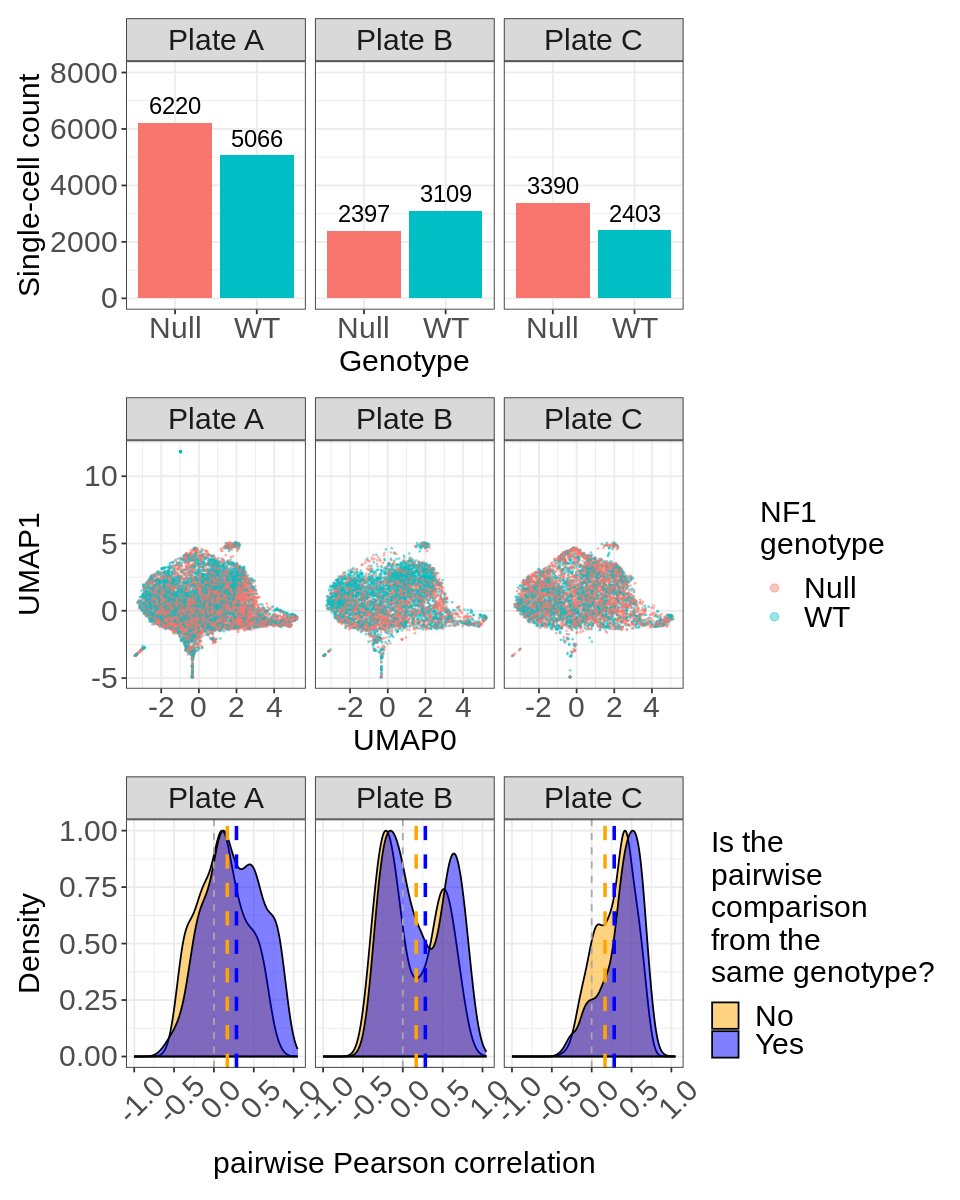

In [9]:
align_plot <- (
    histogram_plot /
    umap_fig_gg /
    genotype_corr_gg
) + plot_layout(heights= c(2,2,2))

align_plot

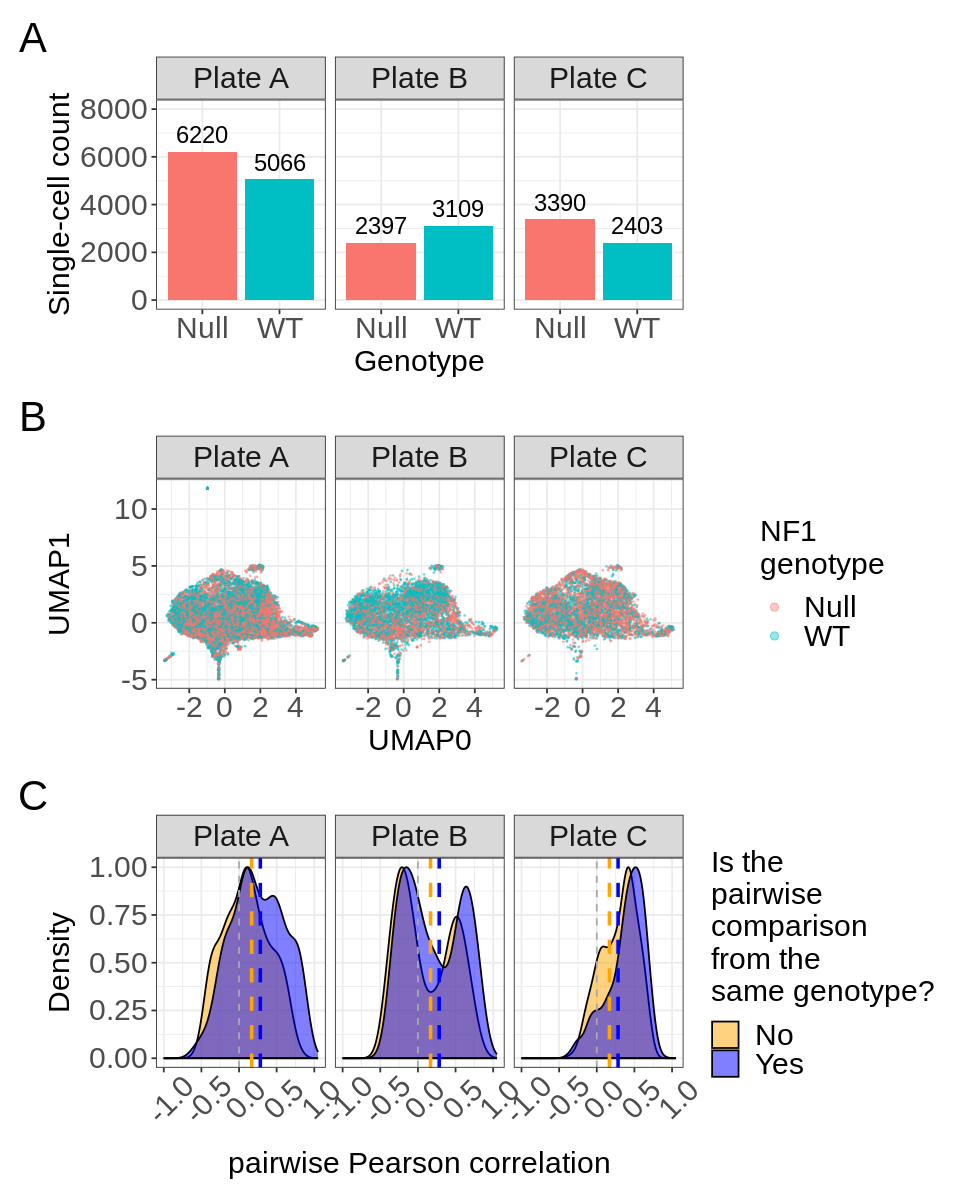

In [10]:
supp_fig_1_gg <- (
  align_plot
) + plot_annotation(tag_levels = "A") & theme(plot.tag = element_text(size = 25))

# Save or display the plot
ggsave(output_supp_figure_1, plot = supp_fig_1_gg, dpi = 500, height = 10, width = 9)

supp_fig_1_gg